## K-Nearest Neighbor Tutorial ##

In this tutorial, we'll explore how to use KNN to cluster data using the MNIST dataset (from K-Means tutorial).

#### Importing Packages ####

In [5]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, train_test_split

# I'm extra so I like using my own color palettes
sns.set_style('darkgrid')
reds = ['#4F0A1F', '#7b3d50', '#d63d50']
blues = ['#283D50','#0C958C','#85BDBD']
codes = ['dark', 'medium', 'light']
red = lambda x: reds[codes.index(x)]
blue = lambda x: blues[codes.index(x)]

#### Data Visualization ####
As always, let's start by visualizing some of our data. We need to know the shape of the input (X) data and the classes (y). 

In [6]:
digits_X = np.loadtxt('MNIST_179_digits.txt')
digits_y = np.loadtxt('MNIST_179_labels.txt')

print('MNIST X shape {} and y shape {}'.format(np.shape(digits_X), np.shape(digits_y)))
print('\nPeak at the first 3 rows of MNIST X data')
print(digits_X[0:3,:])
print('\nPeak at the first 3 rows of MNIST y data')
print(digits_y[0:3])

MNIST X shape (1125, 784) and y shape (1125,)

Peak at the first 3 rows of MNIST X data
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

Peak at the first 3 rows of MNIST y data
[7. 1. 9.]


Ok so we know have 784 features, 1125 rows of data, and 3 classes which are either 1, 7, or 9. Now, you might be thinking, why are we just getting 0's for our data?! Unlike in the Iris data where we could just use feature 1 as x and feature 2 as y to graph a row as a point (x,y), our MNIST data consists of 784 that correspond to a pixel for an image. Instead of a coordinate, each value is the pixel brightness on a black and white scale. So, shown above, the first and last 3 values are all 0 because it's just the whitespace at the border of the image. We'll print out an example of a digit by taking one row of the data and plotting each value as a level of brightness.

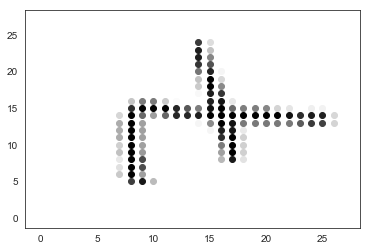

In [7]:
# draws a single number (rotated left)
def draw_digit(row):
    def cal_color(val):
        rgb = 1 - val / 255
        return (rgb, rgb, rgb)

    pixel = 0
    for i in range(0,28):
        for j in range(0,28):
            plt.plot(i,j,'o',color=cal_color(row[pixel]))
            pixel = pixel + 1
    plt.show();
      
sns.set_style('white')
draw_digit(digits_X[0])

#### K-Nearest Neighbor Time ####

KNNs are another way of clustering data such that points are said to belong to a specific class (like '1', '7', or '9'). We start with a **k value** which is the "number of neighbors". All this means is that we these neighbors that are competing with each other over our data set, all of them trying to own the data points. For a neighbor to own that data point, they must 'win' against the others by having the shortest Euclidean distance to that point; in other words, the closest neighbor to a given point determines its class. 

The tricky part is finding how many k values/neighbors to use. To determine this, we'll be splitting our dataset into training and testing data. We'll run the KNN model on the training set trying out different k values. Then, with the best k value, we'll do an accuracy measurement of using that k value on the testing data.

In [8]:
# first split the dataset into (60%) training and (40%) testing
X_train, X_test, y_train, y_test = train_test_split(digits_X, digits_y, test_size=0.40)

In [20]:
def optimal_k(X, y):
    # the maximum k value is usually the sqrt of the number of features
    k_max = int(np.sqrt(len(X)))   
    # store the accuracies for each k_value
    accuracies = []
    k_values = []
    
    # loop over each potential k_values
    # start with a k of 2 because 1 will just group all the points together
    for i in range(2, k_max):
        knn = KNeighborsClassifier(n_neighbors=i)
        knn.fit(X_train, y_train)
        k_values.append(i)
        accuracies.append(knn.score(X_train, y_train))
    
    return k_values, accuracies

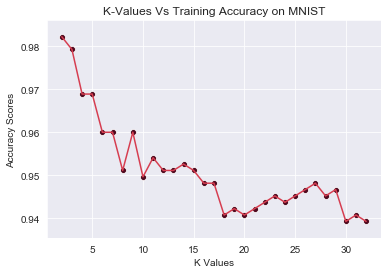

The best k value was 2 with an accuracy of 0.982222222222


In [27]:
# THIS TAKES LIKE A MINUTE TO RUN SO HAVE PATIENCE
k_vals, acc = optimal_k(digits_X, digits_y)

# visualize the k-values
sns.set_style('darkgrid')
sns.scatterplot(k_vals, acc, color=red('dark'))
sns.lineplot(k_vals, acc, color=red('light'))
plt.xlabel('K Values')
plt.ylabel('Accuracy Scores')
plt.title('K-Values Vs Training Accuracy on MNIST')
plt.show();

k_best = k_vals[acc.index(np.amax(acc))]
print('The best k value was {} with an accuracy of {}'.format(k_best, np.amax(acc)))

It's time to get fancier. Instead of just splitting the dataset like we did above, we can use n-fold validation to really make sure we are finding a k-value that will neither be overfitting nor underfitting the data. N-fold validation just splits a dataset n-ways and each split is tested on a k value, the accuracies determined, then tested on the next k-value, and so on. We will plot a graph with the mean accuracies of a 5-fold validation for each k value along with an error bar that shows the min and max values from each fold to see the range.

In [29]:
def error_bars(i, mean, err_min, err_max):
    yerr = np.reshape([err_min, err_max], (2,1))    
    # we want to plot the error bars
    sns.lineplot([i,i], [err_min, err_max], color=red('light'))
    sns.scatterplot([i,i], [err_min, err_max], marker='_', color=red('light'))
    plt.plot(i, mean, 'o', color=blue('medium'))
    
    
def cross_validation(X, y, num_folds):
    cardinality, k_max = len(X), int(np.sqrt(len(X)))
    k_vals = []
    cv_means = []

    # loop over each potential k value
    for i in range(2, k_max):
        knn_cv = KNeighborsClassifier(n_neighbors=i)
        # store all the k-vals used
        k_vals.append(i)
        # loop over CV folds and generate accuracy scores
        cv_acc_per_k_val = cross_val_score(knn_cv, X, y, cv=5)
        mean = np.mean(cv_acc_per_k_val)
        cv_means.append(mean)
        err_min, err_max = np.amin(cv_acc_per_k_val), np.amax(cv_acc_per_k_val)
        # plot all of the current accuracies
        sns.scatterplot(k_vals, cv_means, color='#d63d50')
        # add error bars if desired
        error_bars(i, mean, err_min, err_max)
        
    sns.lineplot(k_vals, cv_means, color=red('dark'))
    plt.xlabel('K Values')
    plt.ylabel('Accuracy Scores')
    plt.title('K-Values Vs N-Fold Mean Training Accuracy on MNIST')
    plt.show()

    k_best = k_vals[cv_means.index(np.amax(cv_means))]
    return np.amax(cv_means), k_best

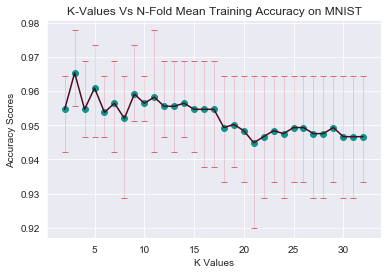

The best k value was 3 with an accuracy of 0.965333333333


In [30]:
acc, k_best = cross_validation(digits_X, digits_y, 5)

print('The best k value was {} with an accuracy of {}'.format(k_best, acc))

#### Validation ####
Now it's more evident that the best k value is 3 so let's determine the accuracy of a k value of 3 on the testing data.

In [32]:
# fit model on training data
knn = KNeighborsClassifier(n_neighbors=3).fit(X_train, y_train)
# score on testing data
score = knn.score(X_test, y_test)
print('Final predictive accuracy score is {}'.format(score))

Final predictive accuracy score is 0.977777777778


This is a really good accuracy score so our work is done!